# COSMOS 2020 Machine Learning Analysis - Margarida Pólvora Fonseca

The objective of this notebook is to use a machine learning regression model on the data of the COSMOS2020 catalog to estimate five main physical characteristics of galaxies, which are:
* Stellar Mass
* Age
* Stellar Formation Rate
* Dust Content
* Metallicity

## Data Pre-Processing
In Topcat, the Classic catalog is crossmatched with the FARMER catalog, to result in a table that contains only sources present in the FARMER but not in the Classic. This table is concatenated to the original Classic catalog. The resulting table is filtered to only contain data from Flux and Magnitude at 3'' aperture, the respective flags from each band, and the data from the LePhare method.

We first import the necessary python libraries, as well as the .csv file with the data we are going to use.

In [2]:
#Import the libraries
import pandas as pd
import numpy as np
import catboost as cb
import shap
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [3]:
# Pedro Cunha function's
def metric_scores_rgr(x,y,redshift):
  """Computes the NMAD, bias, outlier fraction for the regression tasks
  x: ground-truth data
  y: predicted data
  redshift: True or False
  """
  if redshift:
    met = np.abs(pd.Series(y-x))
    f_out = met/(1+x.astype(np.float32))
    nmad=1.48*np.median(f_out)
    bias = np.median(f_out)
    y_outlier = pd.Series(np.where(f_out > 0.15, 'outlier', 'not outlier'))
  else:
    met = np.abs(pd.Series(y-x))
    nmad=1.48*np.median(met)
    bias = np.median(met)
    y_outlier = pd.Series(np.where(met > 0.3, 'outlier', 'not outlier'))
  print("Outliers: \n", y_outlier.value_counts())
  print("\n Bias: \n", bias)
  print("\n NMAD score: \n", nmad)
  print('\n R2 Test: \n', r2_score(x, y))

def plot_feature_importance(importance,names,model_type,number_of_columns):
  """Plots feature importance
  importance: features importance output from model
  names: features names
  model_type: name of the model used to compute features importance
  number_of_columns: number of columns in the graph
  """
  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)
  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)
  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
  fi_df = fi_df.head(number_of_columns)
  #Define size of bar plot
  plt.figure(figsize=(10,5))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + ' Feature Importance')
  plt.xlabel('Feature Importance')
  plt.ylabel('Feature Names')
  plt.show

In [12]:
# My functions
def shap_explainer(model_name,features_values):
    '''Creates a SHAP explainer graph with the top 10 values
    model_name: name of the machine learning model
    features_values: x values used in testing
    '''
    explainer = shap.TreeExplainer(model_name)
    shap_values = explainer.shap_values(features_values)
    shap.summary_plot(shap_values, features_values, max_display = 10, plot_size=[5,5])

def data_visualization(target_name,x,y,redshift):
    '''Graph
    target_name: name of the studied target
    x: ground-truth data
    y: predicted data
    redshift: True or False
    '''
    plt.scatter(x,y,s=0.5)
    plt.xlabel(f'catalog {target_name} value')
    plt.ylabel(f'machine learning {target_name} predicted value')
    plt.title(target_name)
    plt.axline((0, 0), slope=1, color='black')
    if redshift:
        plt.plot([min(y)-0.15*(1+min(y)),max(y)-0.15*(1+max(y))],[min(y),max(y)], color='red', linestyle='dashed')
        plt.plot([min(y)+0.15*(1+min(y)),max(y)+0.15*(1+max(y))],[min(y),max(y)], color='red', linestyle='dashed')
    else:
        plt.plot([min(x),max(x)],[min(x)-0.3,max(x)-0.3], color='red', linestyle='dashed')
        plt.plot([min(x),max(x)],[min(x)+0.3,max(x)+0.3], color='red', linestyle='dashed')

In [4]:
#Import the Catalog
catalog = pd.read_csv(r'D:\Internship IAstro\python output\new data\COSMOS2020_CF_LEPHARE_GALAXIES_MAGFLUX3.csv')

--------------------
## Data Preparation

In [5]:
# Optional: removes rows that are flagged in the different bands
catalog = catalog[catalog.filter(like='_FLAGS').apply(set, axis=1).eq({0})]

In [6]:
# Filters catalog columns
features_list = []
for col_name in list(catalog.columns.values):
        if '_APER3' in col_name: #Magnitude and Flux for Apperture 3
                features_list.append(col_name)

# List of Targets
targets_list = ['lp_age','lp_dust','lp_mass_best','lp_zBEST','lp_SFR_best']

#Creates a new catalog with the columns wanted and removes rows with null values in any column
columns = features_list + targets_list
catalog = catalog[columns].dropna()
# catalog = catalog[catalog[targets_list].notna()]

--------------------
## Machine Learning: Single-output Regression for LePhare using Catboost
### Star-Formation-Rate ('lp_SFR_best')

In [7]:
# Selects the columns
X_table = catalog[features_list]
y_table = catalog['lp_SFR_best']

# Divides data in 70-15-15 ration for test, validation and training
X_train, X_test, y_train_SFR, y_test_SFR = train_test_split(X_table, y_table, test_size=0.3, random_state=42)
X_test, X_val, y_test_SFR, y_val_SFR = train_test_split(X_test, y_test_SFR, test_size=0.5, random_state=42)

train_dataset_SFR = cb.Pool(X_train, y_train_SFR)


# Creates and fits ML model to data
model_SFR = cb.CatBoostRegressor(nan_mode='Min', silent=True, iterations= 1000, depth=6)
model_SFR.fit(X_train, y_train_SFR)

# Predicts values from test data
y_pred_test_SFR = model_SFR.predict(X_test)

# Predicts values from validation
y_pred_val_SFR = model_SFR.predict(X_val)

In [ ]:
data_visualization('SFR',y_test_SFR, y_pred_test_SFR,False)

data_visualization('SFR',y_val_SFR, y_pred_val_SFR,False)

In [ ]:
plt.hist(y_test_SFR, alpha=0.55, label='y_test_SFR')
plt.hist(y_pred_test_SFR, alpha=0.55, label='y_pred_test_SFR')
plt.hist(y_pred_val_SFR, alpha=0.55, label='y_pred_val_SFR')
plt.legend()
plt.show

In [ ]:
# Get ML metrics
print('The metrics for test are:')
metric_scores_rgr(y_test_SFR, y_pred_test_SFR,False)
print('----------------------------------------')
print('The metrics for validation are:')
metric_scores_rgr(y_val_SFR, y_pred_val_SFR,False)
print('----------------------------------------')
print(model_SFR.get_all_params())

In [ ]:
shap_explainer(model_SFR,X_test)
shap_explainer(model_SFR,X_val)

# Pedro Cunha function
features_importances = model_SFR.feature_importances_
names = list(X_train.columns.values)
model_type = 'CatBoost'
number_of_columns = 10 
plot_feature_importance(features_importances,names,model_type, number_of_columns)

### Star-Mass 'lp_mass_best'

In [8]:
# Selects the columns
X_table = catalog[features_list]
y_table = catalog['lp_mass_best']

# Divides data in 70-15-15 ration for test, validation and training
X_train, X_test, y_train_mass, y_test_mass = train_test_split(X_table, y_table, test_size=0.3, random_state=42)
X_test, X_val, y_test_mass, y_val_mass = train_test_split(X_test, y_test_mass, test_size=0.5, random_state=42)

train_dataset_mass = cb.Pool(X_train, y_train_mass)

# Creates and fits ML model to data
model_mass = cb.CatBoostRegressor(nan_mode='Min',
                                silent=True,
                                iterations= 1000,
                                depth=8)
model_mass.fit(X_train, y_train_mass)

# Predicts values from test data and validation data
y_pred_test_mass = model_mass.predict(X_test)
y_pred_val_mass = model_mass.predict(X_val)

In [ ]:
data_visualization('mass', y_test_mass, y_pred_test_mass,False)

In [ ]:
data_visualization('mass', y_val_mass, y_pred_val_mass,False)

In [ ]:
plt.hist(y_test_mass, alpha=0.65, label='y_test_mass')
plt.hist(y_pred_test_mass, alpha=0.65, label='y_pred_test_mass')
plt.hist(y_pred_val_mass, alpha=0.65, label='y_pred_val_mass')
plt.legend()

# Get ML metrics
print('The metrics for test are:')
metric_scores_rgr(y_test_mass, y_pred_test_mass,False)
print('----------------------------------------')
print('The metrics for validation are:')
metric_scores_rgr(y_val_mass, y_pred_val_mass,False)

In [ ]:
shap_explainer(model_mass,X_test)
shap_explainer(model_mass,X_val)

# Pedro Cunha function
features_importances = model_mass.feature_importances_
names = list(X_train.columns.values)
model_type = 'CatBoost'
number_of_columns = 10
plot_feature_importance(features_importances,names,model_type, number_of_columns)

### Age (lp_age)

In [ ]:
# Selects the columns
X_table = catalog[features_list]
y_table = catalog['lp_age']

# Divides data in 70-15-15 ration for test, validation and training
X_train, X_test, y_train_age, y_test_age = train_test_split(X_table, y_table, test_size=0.3, random_state=42)
X_test, X_val, y_test_age, y_val_age = train_test_split(X_test, y_test_age, test_size=0.5, random_state=42)

train_dataset_age = cb.Pool(X_train, y_train_age)

# Creates and fits ML model to data
model_age = cb.CatBoostRegressor(nan_mode='Min',
                                silent=True,
                                iterations= 1000,
                                depth=8)
model_age.fit(X_train, y_train_age)

# Predicts values from test data and validation data
y_pred_test_age = model_age.predict(X_test)
y_pred_val_age = model_age.predict(X_val)

In [ ]:
data_visualization('age', y_test_age, y_pred_test_age,False)

In [ ]:
data_visualization('age', y_val_age, y_pred_val_age,False)

In [ ]:
# Get ML metrics
print('The metrics for test are:')
metric_scores_rgr(y_test_age, y_pred_test_age,False)
print('----------------------------------------')
print('The metrics for validation are:')
metric_scores_rgr(y_val_age, y_pred_val_age,False)

#SHAP
shap_explainer(model_age,X_test)
shap_explainer(model_age,X_val)

# Pedro Cunha function
features_importances = model_age.feature_importances_
names = list(X_train.columns.values)
model_type = 'CatBoost'
number_of_columns = 10
plot_feature_importance(features_importances,names,model_type, number_of_columns)

### Redshift (lp_zBest)

In [ ]:
# Selects the columns
X_table = catalog[features_list]
y_table = catalog['lp_zBEST']

# Divides data in 70-15-15 ration for test, validation and training
X_train, X_test, y_train_z, y_test_z = train_test_split(X_table, y_table, test_size=0.3, random_state=42)
X_test, X_val, y_test_z, y_val_z = train_test_split(X_test, y_test_z, test_size=0.5, random_state=42)

train_dataset_z = cb.Pool(X_train, y_train_z)

# Creates and fits ML model to data
model_z = cb.CatBoostRegressor(nan_mode='Min',
                                silent=True,
                                iterations= 1000,
                                depth=8)
model_z.fit(X_train, y_train_z)

# Predicts values from test data and validation data
y_pred_test_z = model_z.predict(X_test)
y_pred_val_z = model_z.predict(X_val)

In [ ]:
data_visualization('redshift', y_test_z, y_pred_test_z,False)

In [ ]:
data_visualization('redshift', y_val_z, y_pred_val_z,False)

In [ ]:
plt.hist(y_test_z, alpha=0.55, label='y_test_z')
plt.hist(y_pred_test_z, alpha=0.55, label='y_pred_test_z')
plt.hist(y_pred_val_z, alpha=0.55, label='y_pred_val_z')
plt.legend()

In [ ]:
# Get ML metrics
print('The metrics for test are:')
metric_scores_rgr(y_test_z, y_pred_test_z,True)
print('----------------------------------------')
print('The metrics for validation are:')
metric_scores_rgr(y_val_z, y_pred_val_z,True)

# SHAP
shap_explainer(model_z,X_test)
shap_explainer(model_z,X_val)

# Pedro Cunha function
features_importances = model_z.feature_importances_ #replace model by your model
names = list(X_train.columns.values) #list of the columns from the X_train data set
model_type = 'CatBoost' # change according to the model to be used. Only used in the plots.
number_of_columns = 10
plot_feature_importance(features_importances,names,model_type, number_of_columns)

### Dust (lp_dust)

In [ ]:
# Selects the columns
X_table = catalog[features_list]
y_table = catalog['lp_dust']

# Divides data in 70-15-15 ration for test, validation and training
X_train, X_test, y_train_dust, y_test_dust = train_test_split(X_table, y_table, test_size=0.3, random_state=42)
X_test, X_val, y_test_dust, y_val_dust = train_test_split(X_test, y_test_dust, test_size=0.5, random_state=42)

train_dataset_dust = cb.Pool(X_train, y_train_dust)

# Creates and fits ML model to data
model_dust = cb.CatBoostRegressor(nan_mode='Min',
                                silent=True,
                                iterations= 1000,
                                depth=8)
model_dust.fit(X_train, y_train_dust)

# Predicts values from test data and validation data
y_pred_test_dust = model_dust.predict(X_test)
y_pred_val_dust = model_dust.predict(X_val)


In [ ]:
data_visualization('dust', y_test_z, y_pred_test_z,False)

In [ ]:
data_visualization('dust', y_val_z, y_pred_val_z,False)

In [ ]:
plt.hist(y_test_dust, alpha=0.55, label='y_test_dust')
plt.hist(y_pred_test_dust, alpha=0.55, label='y_pred_test_dust')
plt.hist(y_pred_val_dust, alpha=0.55, label='y_pred_val_dust')
plt.legend()

In [ ]:
# Get ML metrics
print('The metrics for test are:')
metric_scores_rgr(y_test_dust, y_pred_test_dust,False)
print('----------------------------------------')
print('The metrics for validation are:')
metric_scores_rgr(y_val_dust, y_pred_val_dust,False)

# SHAP 
shap_explainer(model_dust,X_test)
shap_explainer(model_dust,X_val)

# Pedro Cunha function
features_importances = model_dust.feature_importances_ #replace model by your model
names = list(X_train.columns.values) #list of the columns from the X_train data set
model_type = 'CatBoost' # change according to the model to be used. Only used in the plots.
number_of_columns = 10
plot_feature_importance(features_importances,names,model_type, number_of_columns)

--------------------
## Stellar Mass vs Star Formation Rate

Text(0, 0.5, 'Star Formation Rate')

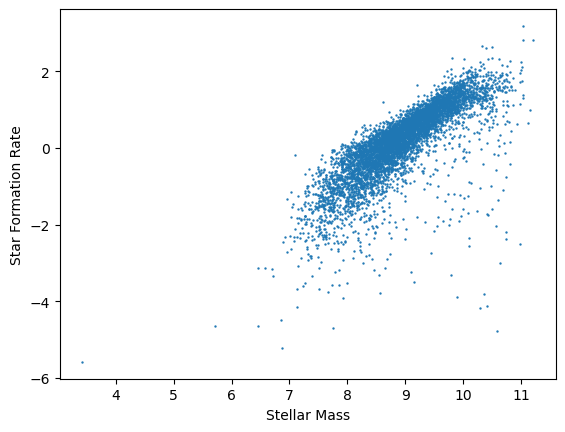

In [10]:
plt.scatter(y_pred_test_mass, y_pred_test_SFR, s=0.5)
plt.xlabel('Stellar Mass')
plt.ylabel('Star Formation Rate')